# Streamlining Workflows with Pipelines

## Loading the Breast Cancer Wisconsin dataset 

In [1]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

In [2]:
Version(sklearn_version)

LooseVersion ('0.18.1')

In [3]:
import pandas as pd 

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
df.shape

(569, 32)

In [6]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:,2:].values
y = df.loc[:,1].values
le = LabelEncoder()
y = le.fit_transform(y)

In [7]:
le.transform(['M','B'])

array([1, 0])

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

## Combining transformers and estimators in a pipeline

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [10]:
pipe_lr = Pipeline([
        ('scl', StandardScaler()),
        ('pca', PCA(n_components=2)),
        ('clf', LogisticRegression(random_state=1))
    ])

pipe_lr.fit(X_train,y_train)

Pipeline(steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [11]:
print 'Train Accuracy %.5s'%pipe_lr.score(X_train,y_train)
print 'Test Accuracy %.5s'%pipe_lr.score(X_test,y_test)

Train Accuracy 0.953
Test Accuracy 0.947


In [12]:
import numpy as np
from __future__ import division

np.sum(pipe_lr.predict(X_test)==y_test)/y_test.shape[0]

0.94736842105263153

# Using k-fold cross validation to assess model performance

## The holdout method

In [48]:
from sklearn.model_selection import StratifiedKFold
from time import time

In [51]:
t0 = time()
k_fold= StratifiedKFold(n_splits=10,
                        random_state=1).split(X_train,y_train)
scores = []
for k, (train,test) in enumerate(k_fold):
#     print k, train.shape, test.shape
#     print y_train[train,:]
#     break
    pipe_lr.fit(X_train[train],y_train[train])
    score = pipe_lr.score(X_train[test],y_train[test])
    scores.append(score)
    print 'Fold %i, Accuracy: %.3f'%(k+1, score)
print "\ntraining time:", round(time()-t0, 3), "s"

Fold 1, Accuracy: 0.891
Fold 2, Accuracy: 0.978
Fold 3, Accuracy: 0.978
Fold 4, Accuracy: 0.913
Fold 5, Accuracy: 0.935
Fold 6, Accuracy: 0.978
Fold 7, Accuracy: 0.933
Fold 8, Accuracy: 0.933
Fold 9, Accuracy: 0.978
Fold 10, Accuracy: 0.956

training time: 0.056 s


In [52]:
from sklearn.cross_validation import cross_val_score

In [53]:
t0 = time()

scores= cross_val_score(estimator=pipe_lr,
                       X=X_train,
                       y=y_train,
                       cv=10,
                       n_jobs=1)
print 'CV accuracy scores: %s' % scores
print "\ntraining time:", round(time()-t0, 3), "s\n"
print 'CV accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores))


CV accuracy scores: [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.93333333  0.97777778  0.95555556]

training time: 0.114 s

CV accuracy: 0.947 +/- 0.029


# Debugging algorithms with learning curves

## Diagnosing bias and variance problems with learning curves

In [54]:
import matplotlib.pylab as plt
%matplotlib inline
from sklearn.model_selection import learning_curve

In [55]:
pipe_lr = Pipeline([
        ('scl', StandardScaler()),
        ('clf', LogisticRegression(penalty='l2', random_state=0))
    ])

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes=np.linspace(0.1,1.0,10),
                                                       cv=10,
                                                       n_jobs=1)

In [19]:
train_sizes

array([ 40,  81, 122, 163, 204, 245, 286, 327, 368, 409])

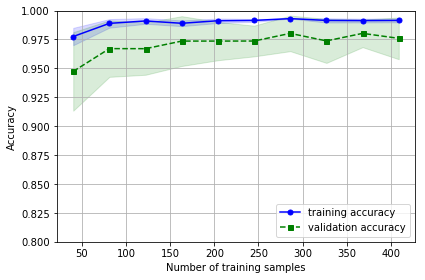

In [20]:
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

<br>
## Addressing over- and underfitting with validation curves

In [21]:
from sklearn.model_selection import validation_curve

In [22]:
param_range= [0.001, 0.01, 0.1, 1, 10, 100]
train_scores, test_scores = validation_curve(estimator=pipe_lr,
                                            X=X_train,
                                            y=y_train,
                                            param_name='clf__C',
                                            param_range=param_range,
                                            cv=10)

In [23]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

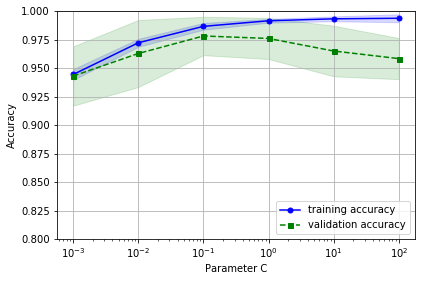

In [24]:
plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('./figures/validation_curve.png', dpi=300)
plt.show()

<br>
# Fine-tuning machine learning models via grid search

## Tuning hyperparameters via grid search

In [25]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [26]:
pipe_svc = Pipeline([
        ('scl', StandardScaler()),
        ('clf', SVC(random_state=1))])

param_range = [0.0001*10**e for e in range(8)]
param_grid = [{'clf__C' : param_range,
               'clf__kernel' : ['linear']},
              {'clf__C' : param_range,
               'clf__gamma' : param_range,
               'clf__kernel' : ['rbf']},]

gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=10,
                 n_jobs=-1)

gs = gs.fit(X_train,y_train)

In [27]:
print gs.best_params_
print gs.best_score_

{'clf__C': 0.1, 'clf__kernel': 'linear'}
0.978021978022


In [28]:
clf = gs.best_estimator_
clf.fit(X_train,y_train)
print 'Test accuracy: %.3f' %clf.score(X_test,y_test)

Test accuracy: 0.965


<br>
# Algorithm selection with nested cross-validation

In [29]:
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5 )

In [30]:
print 'CV accuracy: %.3f +/- %.3f' %(np.mean(scores),np.std(scores))

CV accuracy: 0.965 +/- 0.025


In [31]:
from sklearn.tree import DecisionTreeClassifier

In [32]:
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid= [{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)

In [33]:
print 'CV accuracy: %.3f +/- %.3f' %(np.mean(scores),np.std(scores))

CV accuracy: 0.921 +/- 0.029


<br>
# Looking at different performance evaluation metrics

In [34]:
from sklearn.metrics import confusion_matrix

In [35]:
pipe_svc.fit(X_train,y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print confmat

[[71  1]
 [ 2 40]]


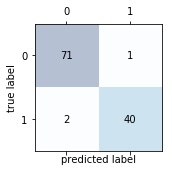

In [36]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
plt.show()

In [37]:
# check the class labels 
le.transform(['M', 'B'])

array([1, 0])

In [38]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=le.transform(['M', 'B']))
print confmat

[[40  2]
 [ 1 71]]


Assuming that class 1 (malignant) is the positive class in this example, our model correctly classified 71 of the samples that belong to class 0 (true negatives) and 40 samples that belong to class 1 (true positives), respectively. However, our model also incorrectly misclassified 1 sample from class 0 as class 1 (false positive), and it predicted that 2 samples are benign although it is a malignant tumor (false negatives).

## Optimizing the precision and recall of a classification model

In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [71]:
# there is pos_label parameter for all functions, pos_label=1
print 'precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred) 
print 'recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred)
print 'f1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred)

precision: 0.976
recall: 0.952
f1: 0.964


The default positive class in sklearn in class 1. If a different positive label is wanted, a new scorer can be build.

In [78]:
from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score, pos_label=0)

c_gamma_range = [0.01, 0.1, 1, 10]

param_grid = [{'clf__C': c_gamma_range,
               'clf__kernel': ['linear']},
              {'clf__C': c_gamma_range,
               'clf__gamma': c_gamma_range,
               'clf__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring=scorer,
                 cv=10,
                 n_jobs=-1)
gs = gs.fit(X_train, y_train)
print gs.best_score_
print gs.best_params_

0.982798668208
{'clf__C': 0.1, 'clf__kernel': 'linear'}



# Plotting a receiver operating characteristic

In [44]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

In [45]:
pipe_lr = Pipeline([
        ('scl', StandardScaler()),
        ('pca', PCA(n_components=2)),
        ('clf', LogisticRegression(penalty='l2',
                                   random_state=0,
                                   C=100))
    ])

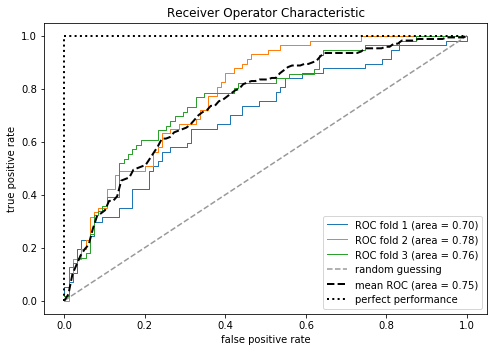

In [122]:
X_train2 = X_train[:,[4,14]]

cv = list(StratifiedKFold(n_splits=3,random_state=1).split(X_train,y_train))

fig = plt.figure(figsize=(7,5))

mean_tpr = 0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in  enumerate(cv):
    # calculate class probabilties of the test set
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    
    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)   
    all_tpr.append(tpr)
    mean_tpr[0] = 0
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr,
             tpr,
             lw=1,
             label='ROC fold %d (area = %0.2f)' %(i+1, roc_auc))

# Diagonal line
plt.plot([0,1],
         [0,1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')    

# Mean ROC
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)

# Perfect Performance 
plt.plot([0, 0, 1],
         [0, 1, 1],
         lw=2,
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")

plt.tight_layout()

plt.show()

In [176]:
# create the class probabilities for the test set
pipe_lr = pipe_lr.fit(X_train2,y_train)
y_labels = pipe_lr.predict(X_test[:,[4,14]])
y_probas = pipe_lr.predict_proba(X_test[:,[4,14]])[:,1]

In [181]:
# directly calculate AUC score
from sklearn.metrics import roc_auc_score, accuracy_score

print 'ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_probas)
print 'Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_labels)

ROC AUC: 0.751
Accuracy: 0.711
